In [4]:
import re, os
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from peft import PeftModel
import numpy as np 
import random



from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging
)



def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)



model_name = "RikoteMaster/llama2_working_merged_loras"

print(f"Starting to load the model {model_name} into memory")



################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

#################################


bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=getattr(torch, bnb_4bit_compute_dtype),
    bnb_4bit_use_double_quant=use_nested_quant,
)


#LOADING MODEL WITH MERGED LORAS
m = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map={"": 0}
)

print(m)

m.config.use_cache = False
m.config.pretraining_tp = 1



# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

Starting to load the model RikoteMaster/llama2_working_merged_loras into memory


Loading checkpoint shards: 100%|██████████| 6/6 [00:08<00:00,  1.43s/it]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRM

In [3]:
text = f"""[INST] In this task, you will be performing a classification exercise aimed at identifying the underlying emotion conveyed by a given sentence. The emotions to consider are as follows: Anger, Joy, Sadnes, Guilt, Shame, fear or disgust Sentence: {"I feel so frightened"} [/INST] """

inputs = tokenizer(text, return_tensors='pt')
max_new_tokens = 3

from transformers import GenerationConfig
generation_config = GenerationConfig(
    temperature=0.1,
    top_p=0.4,
    repetition_penalty=1.1,
    do_sample=True
)
with torch.inference_mode():
    result = m.generate(
        input_ids=inputs['input_ids'],
        generation_config=generation_config,
        return_dict_in_generate=True,
        output_scores=True,
        max_new_tokens=max_new_tokens,
        output_attentions=True,
        output_hidden_states=True
    )
    

tokenizer.decode(result.sequences[0])

You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.


'<s> [INST] In this task, you will be performing a classification exercise aimed at identifying the underlying emotion conveyed by a given sentence. The emotions to consider are as follows: Anger, Joy, Sadnes, Guilt, Shame, fear or disgust Sentence: I feel so frightened [/INST]  fear <s>'

In [4]:
print('WHAT THE METHOD IS RETURNING TO US')
print(result.keys())
print('-'*100, '\n')
print('SCORES')
#First we have the sequences value
print("These are the scores of the model, shape (3,32000).\n First dimension due to max_new_tokens and second one is vocab model size")
print("These will return the token the model should generate")
print(result.scores)
print('-'*100, '\n')
print('SEQUENCES')
print("These are the tokens of the model with the three iterations and selecting which word to generate")
print(result.sequences)
print('-'*100, '\n')
print('ATTENTIONS')
print("These are the attention weights for each layer for each head attention, shape is (3,32,32,74)\n You have to be careful. The first value is the size due to word generation. The second and third are characteristics of the model, and the fourth is len(input) + max_new_tokens")
print("result.attentions")
print('-'*100, '\n')
print('HIDDEN STATES')
print("""These are the values of each layer, the ones that are propagating between the 32 layers. The size is (3,32,4096).\n
First one due to number of layers and second one is the token embedding size. """)

print("PAST KEY VALUES...")



WHAT THE METHOD IS RETURNING TO US
odict_keys(['sequences', 'scores', 'attentions', 'hidden_states', 'past_key_values'])
---------------------------------------------------------------------------------------------------- 

SCORES
These are the scores of the model, shape (3,32000).
 First dimension due to max_new_tokens and second one is vocab model size
These will return the token the model should generate
(tensor([[-inf, -inf, -inf,  ..., -inf, -inf, -inf]]), tensor([[-inf, -inf, -inf,  ..., -inf, -inf, -inf]]), tensor([[    -inf, 263.7784,     -inf,  ...,     -inf,     -inf,     -inf]]))
---------------------------------------------------------------------------------------------------- 

SEQUENCES
These are the tokens of the model with the three iterations and selecting which word to generate
tensor([[    1,   518, 25580, 29962,   512,   445,  3414, 29892,   366,   674,
           367, 15859,   263, 12965, 15058, 12242,   287,   472,  2893,  9215,
           278, 14407,   953,  819

In [5]:
def min_max_normalization(matrix: torch.tensor, dim: int, masked: bool) -> torch.tensor:
    ''' This function will normalize the matrix using the min-max normalization technique

    Args:
    - matrix: the matrix to normalize
    - dim: the dimension to normalize
    - masked: if the matrix has to be masked or not
    Returns:
    - normalized_matrix: the normalized matrix
    
    '''

    maximum_value = matrix.max(dim=dim, keepdim=True).values
    maximum_value_matrix = maximum_value.repeat([1, matrix.shape[dim]]) if dim==1 else maximum_value.repeat([matrix.shape[dim], 1])

    mask = matrix==0 if masked else torch.tensor(False)

    minimum_value = matrix.masked_fill(mask, 1e9).min(dim=dim, keepdim=True).values
    minimum_value_matrix = minimum_value.repeat([1, matrix.shape[dim]]) if dim==1 else minimum_value.repeat([matrix.shape[dim], 1])
    
    mask2 = minimum_value_matrix == maximum_value_matrix

    normalized_matrix = (matrix - minimum_value_matrix) / (maximum_value_matrix - minimum_value_matrix)

    #apply mask2 and mask
    normalized_matrix = normalized_matrix.masked_fill(mask2, 1)
    normalized_matrix = normalized_matrix.masked_fill(mask, 0)


    return normalized_matrix
    
    

matrix = result.attentions[1][0][0].mean(dim=0).float()

min_max_normalization(matrix, 1, True)


tensor([[0.0000, 0.1839, 0.2339, 0.3474, 0.3320, 0.4723, 0.1981, 0.7136, 0.2250,
         0.4089, 0.4727, 0.2152, 0.5907, 0.2331, 0.1892, 0.1766, 0.6550, 0.6615,
         0.1334, 0.3393, 0.7152, 0.2278, 0.2429, 0.2819, 0.1186, 0.6794, 0.5989,
         0.6721, 0.4516, 0.3442, 0.3999, 0.4508, 0.2567, 0.3991, 0.6509, 0.2372,
         0.5818, 0.4154, 0.2807, 0.3983, 0.3039, 0.2917, 0.7705, 0.2771, 0.8568,
         0.4504, 0.3613, 0.8096, 0.3165, 0.2836, 0.7681, 0.4032, 0.4337, 0.8373,
         0.3161, 0.5346, 0.3775, 0.4223, 0.3385, 0.3938, 0.3751, 0.6241, 0.4312,
         0.4605, 0.4422, 0.5289, 0.5346, 0.5590, 0.6957, 0.8714, 0.7469, 1.0000,
         0.9504]])

In [6]:
#Developping attention rollout #weighetd ? 

import matplotlib.pyplot as plt
import seaborn as sns
import numpy 

tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids.squeeze())
length_sentence = len(inputs['input_ids'][0])
normalized_attention = torch.zeros(32, length_sentence, length_sentence)
full_results = torch.zeros(32, length_sentence+max_new_tokens, length_sentence+max_new_tokens)
for i in range(32): 
    aux_result = result.attentions[0][i][0].mean(dim=0).float()

    #filtering null attention "https://aclanthology.org/W19-4808.pdf"
    aux_result[:,0] = 0
    # aux_result = min_max_normalization(aux_result, 1, True)
    full_results[i][0:length_sentence, 0:length_sentence] = aux_result
    for j in range(1, max_new_tokens):
        
        new_token = result.attentions[j][i][0].mean(dim=0).float()
        new_token[:,0] = 0
        # new_token = min_max_normalization(new_token, 1, True)


        full_results[i][length_sentence + j - 1][0:length_sentence+j] = new_token
    #first token is a matrix of 1,73 and full_results[i] is a matrix of 72,72 so wwe have to add a null column to the full_results and after concatenate the first token
    eye_matrix = torch.eye(length_sentence+max_new_tokens, length_sentence+max_new_tokens)
    #full_results[i] = (full_results[i]*0.5 + eye_matrix*0.5) * full_results[i-1] if i > 0 else full_results[i]
    full_results[i] = min_max_normalization(full_results[i], 0, True)
        
tokens = tokenizer.convert_ids_to_tokens(result.sequences[0])



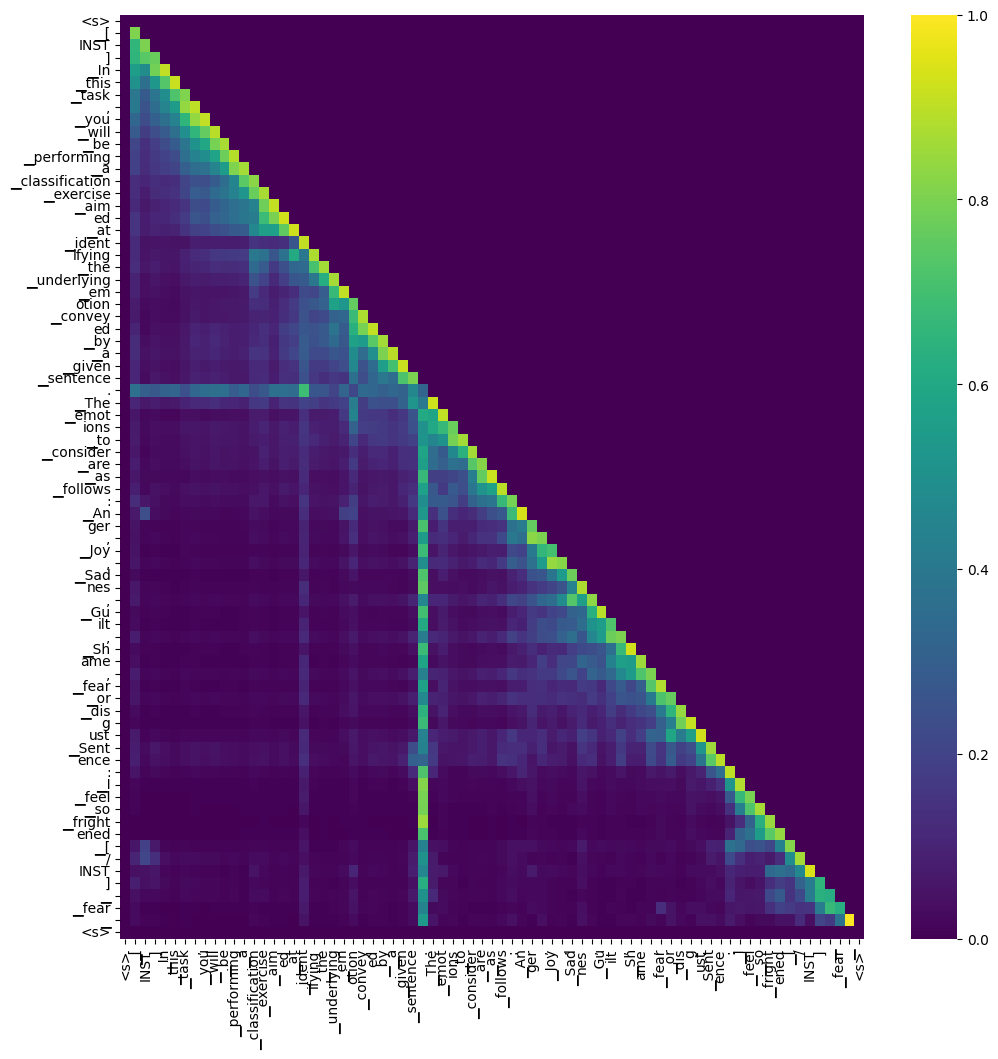

In [7]:
plt.figure(figsize=(12, 12))
sns.heatmap(full_results.mean(dim = 0), annot=False, cmap='viridis', xticklabels = tokens, yticklabels = tokens)
plt.show()




In [8]:

import imageio

# Assuming full_results is already computed as shown in your code snippet.

filenames = []

for i in range(full_results.shape[0]):
    plt.figure(figsize=(15, 15))
    sns.heatmap(full_results[i], annot=False, cmap='viridis', xticklabels = tokens[:-3], yticklabels = tokens[:-3])    
    filename = f'./GIF/heatmap_layer_{i}.png'
    plt.savefig(filename)
    plt.close()
    filenames.append(filename)

# Create a GIF
with imageio.get_writer('./GIF/heatmap_animation.gif', mode='I', duration=2) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove files
# for filename in filenames:
#     os.remove(filename)

print("GIF created at './GIF/heatmap_animation.gif'")


Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


GIF created at './GIF/heatmap_animation.gif'


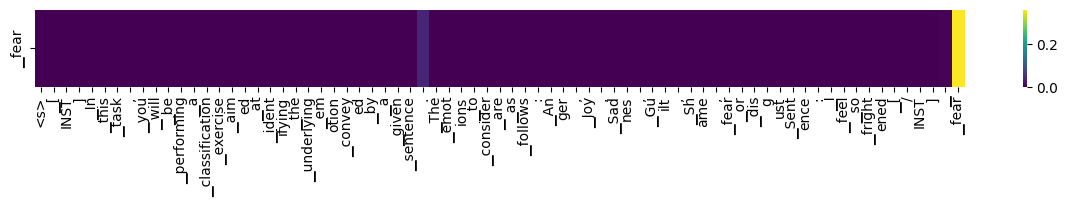

In [9]:
#Now analyzing the attentions of the new tokens
# In order to make a good analysis we are going to first search over the different layers in a transformer to the different attention mechanism 
#Lets analyze the first layer at token generation_0 
timestamp = 1
length_sentence = len(inputs['input_ids'][0]) + timestamp
full_results = torch.zeros(32,length_sentence)


for i in range(32): 
    aux_result = result.attentions[timestamp][i][0].mean(dim=0).float()
    
    maximum_values = aux_result.max(dim=1).values
    

    
    minimum_values = aux_result.min(dim=1).values
    
    aux_result_normalized = (aux_result - minimum_values)/(maximum_values - minimum_values)


    eye = torch.zeros(1, length_sentence)
    eye[0,length_sentence-1] = 1

    (aux_result_normalized*0.5 + eye ) * full_results[i-1]

    full_results[i] = (aux_result_normalized*0.5 + eye*0.5 ) * full_results[i-1] if i != 0 else (aux_result_normalized*0.5 + eye*0.5 )
        


plt.figure(figsize=(15, 1))
sns.heatmap(full_results[2].reshape(length_sentence,1).T, annot=False, cmap='viridis', \
            xticklabels=tokenizer.convert_ids_to_tokens(result.sequences[0][:length_sentence]),\
            yticklabels=[tokenizer.convert_ids_to_tokens(result.sequences[0][:length_sentence])[-1]])

plt.show()

In [10]:
filenames = []

for i in range(full_results.shape[0]):
    plt.figure(figsize=(20, 2))
    plt.figure(figsize=(15, 1))
    sns.heatmap(full_results[i].reshape(length_sentence,1).T, annot=False, cmap='viridis', \
            xticklabels=tokenizer.convert_ids_to_tokens(result.sequences[0][:length_sentence]),\
            yticklabels=[tokenizer.convert_ids_to_tokens(result.sequences[0][:length_sentence])[-1]])

                
    filename = f'./GIF/heatmap_layer_timestamp{timestamp}{i}.png'
    plt.savefig(filename)
    plt.close()
    filenames.append(filename)

# Create a GIF
with imageio.get_writer('./GIF/heatmap_animation_timestamp{timestamp}.gif', mode='I', duration=0.5) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove files
for filename in filenames:
    os.remove(filename)

print("GIF created at './GIF/heatmap_animation.gif'")

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


GIF created at './GIF/heatmap_animation.gif'


<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

<Figure size 2000x200 with 0 Axes>

In [11]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

def aggregate_attention(attn):
    '''Extract average attention vector'''
    avged = []
    for layer in attn:
        layer_attns = layer.squeeze(0)
        attns_per_head = layer_attns.mean(dim=0)
        vec = torch.concat((
            # We zero the first entry because it's what's called
            # null attention (https://aclanthology.org/W19-4808.pdf)
            torch.tensor([0.]),
            # usually there's only one item in attns_per_head but
            # on the first generation, there's a row for each token
            # in the prompt as well, so take [-1]
            attns_per_head[-1][1:],
            # add zero for the final generated token, which never
            # gets any attention
            torch.tensor([0.]),
        ))
        avged.append(vec / vec.sum())
    return torch.stack(avged).mean(dim=0)

def heterogenous_stack(vecs):
    '''Pad vectors with zeros then stack'''
    max_length = max(v.shape[0] for v in vecs)
    return torch.stack([
        torch.concat((v, torch.zeros(max_length - v.shape[0])))
        for v in vecs
    ])

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

def decode(tokens):
    '''Turn tokens into text with mapping index'''
    full_text = ''
    chunks = []
    for i, token in enumerate(tokens):
        text = tokenizer.decode(token)
        full_text += text
        chunks.append(text)
    return full_text, chunks

def get_completion(prompt):
    '''Get full text, token mapping, and attention matrix for a completion'''
    tokens = tokenizer.encode(prompt, return_tensors="pt")
    outputs = model.generate(
        tokens,
        max_new_tokens=3,
        output_attentions=True,
        return_dict_in_generate=True,
        early_stopping=True,
        length_penalty=-1
    )
    sequences = outputs.sequences
    attn_m = heterogenous_stack([
        torch.tensor([
            1 if i == j else 0
            for j, token in enumerate(tokens[0])
        ])
        for i, token in enumerate(tokens[0])
    ] + list(map(aggregate_attention, outputs.attentions)))
    decoded, tokenized = decode(sequences[0])
    return decoded, tokenized, attn_m

def show_matrix(xs):
    for x in xs:
        line = ''
        for y in x:
            line += '{:.4f}\t'.format(float(y))
        print(line)




Loading checkpoint shards: 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]


In [12]:
decoded, tokenized, attn_m = get_completion(text)

`num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
`num_beams` is set to 1. However, `length_penalty` is set to `-1` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.


<Axes: >

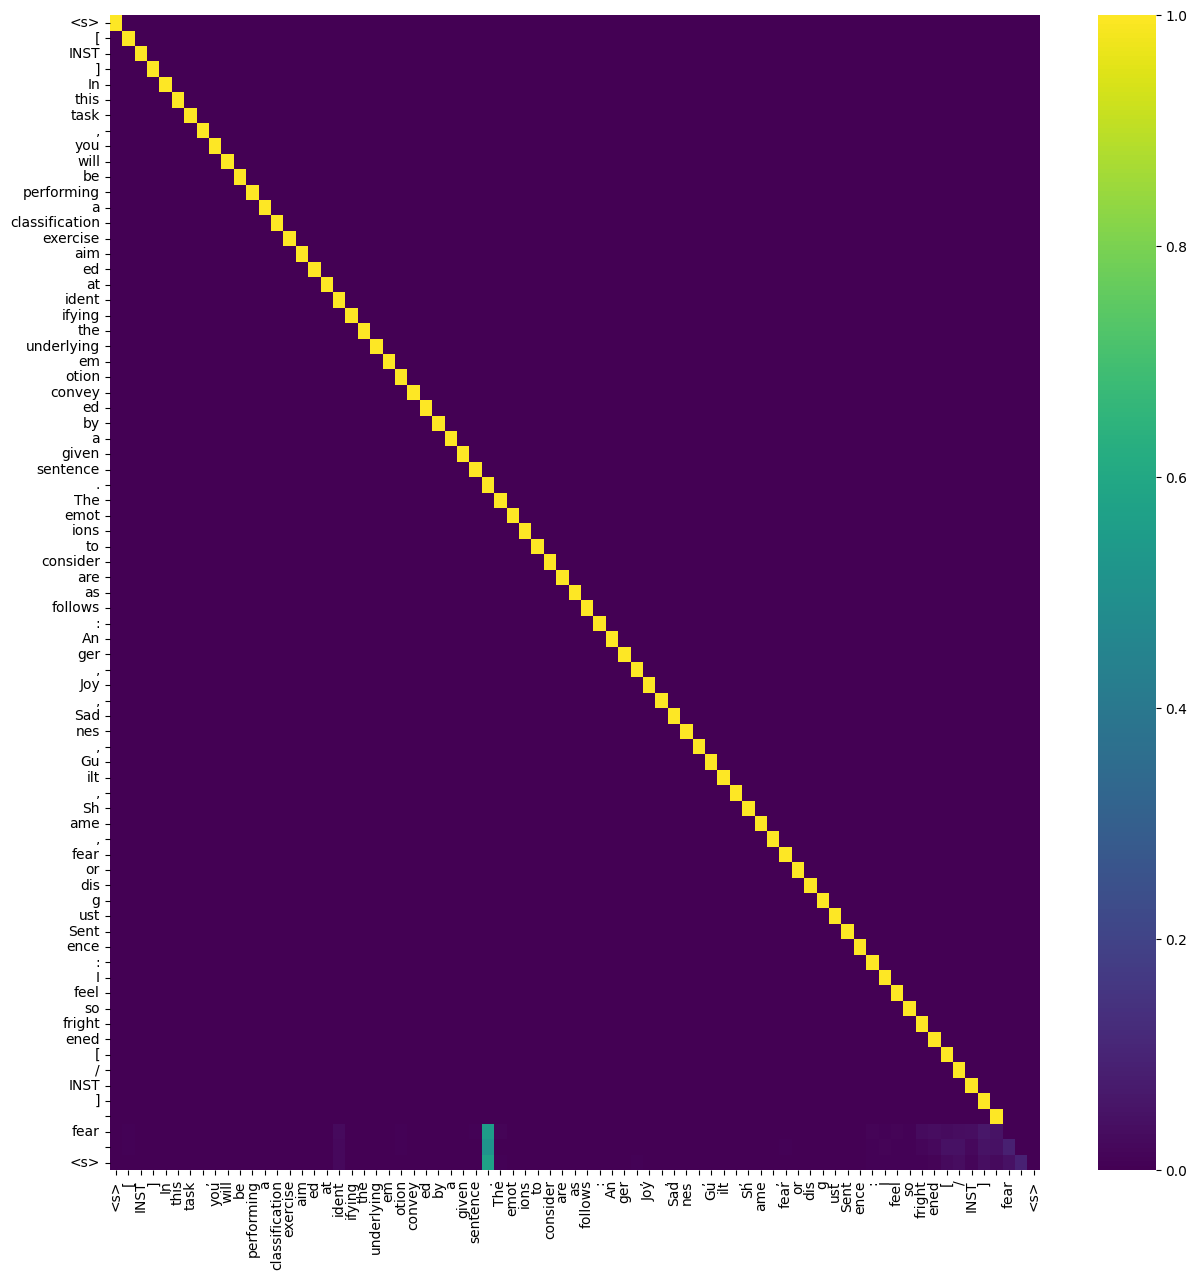

In [13]:
plt.figure(figsize=(15, 15))
sns.heatmap(attn_m, annot=False, cmap='viridis', xticklabels = tokenized, yticklabels = tokenized)

## TRYING SHAP 

In [1]:
!pip install git+https://github.com/shap/shap.git

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/shap/shap.git to /tmp/pip-req-build-w9g7sob6
  Running command git clone --filter=blob:none --quiet https://github.com/shap/shap.git /tmp/pip-req-build-w9g7sob6
  Resolved https://github.com/shap/shap.git to commit 74db96c333c41cee0bb90044f25d8b2dc102cdb6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of shap to determine which version is compatible with other requirements. This could take a while.
ERROR: Package 'shap' requires a different Python: 3.8.10 not in '>=3.9'


In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer

import shap

#load model meta-llama/llama2-hf
tokenizer = AutoTokenizer.from_pretrained("RikoteMaster/llama2_working_merged_loras", use_fast=True)
model = AutoModelForCausalLM.from_pretrained("RikoteMaster/llama2_working_merged_loras").cuda()



/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


In [12]:
s = [f"""[INST] In this task, you will be performing a classification exercise aimed at identifying the underlying emotion conveyed by a given sentence. The emotions to consider are as follows: Anger, Joy, Sadnes, Guilt, Shame, fear or disgust Sentence: {"I love when my mother is laughing, his laugh is so funny"} [/INST] """]
gen_dict = dict(
do_sample = True,
temperature = 0.7, 

max_new_tokens=4,
renormalize_logits=True,
no_repeat_ngram_size=2,
)


model.config.is_decoder = True

model.config.task_specific_params = dict()
model.config.task_specific_params["text-generation"] = gen_dict
shap_model = shap.models.TeacherForcing(model, tokenizer)

masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(shap_model, tokenizer)


In [13]:
result = explainer(s)

shap.plots.text(result)

PartitionExplainer explainer: 2it [00:17, 17.17s/it]               


In [2]:
pip uninstall shap 

Found existing installation: shap 0.44.1
Uninstalling shap-0.44.1:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/shap-0.44.1.dist-info/*
    /usr/local/lib/python3.8/dist-packages/shap/*
Proceed (Y/n)? 

# USING CAPTUM

In [1]:
import bitsandbytes as bnb
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import random
import sys

from captum.attr import (
    FeatureAblation, 
    ShapleyValues,
    LayerIntegratedGradients, 
    LLMAttribution, 
    LLMGradientAttribution, 
    TextTokenInput, 
    TextTemplateInput,
    ProductBaselines,
)

/usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_model(model_name, bnb_config):
    n_gpus = torch.cuda.device_count()
    max_memory = "10000MB"

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto", # dispatch efficiently the model on the available ressources
        max_memory = {i: max_memory for i in range(n_gpus)},
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)

    # Needed for LLaMA tokenizer
    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

def create_bnb_config():
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    return bnb_config

In [3]:
model_name = "RikoteMaster/llama2_working_merged_loras"

bnb_config = create_bnb_config()

model, tokenizer = load_model(model_name, bnb_config)

/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:554: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


RuntimeError: No GPU found. A GPU is needed for quantization.

[INST] In this task, you will be performing a classification exercise aimed at identifying the underlying emotion conveyed by a given sentence. The emotions to consider are as follows: Anger, Joy, Sadnes, Guilt, Shame, fear or disgust Sentence: anger joy joy [/INST]  Joy 
attr to the output sequence: torch.Size([69])
attr to the output tokens: torch.Size([1, 69])


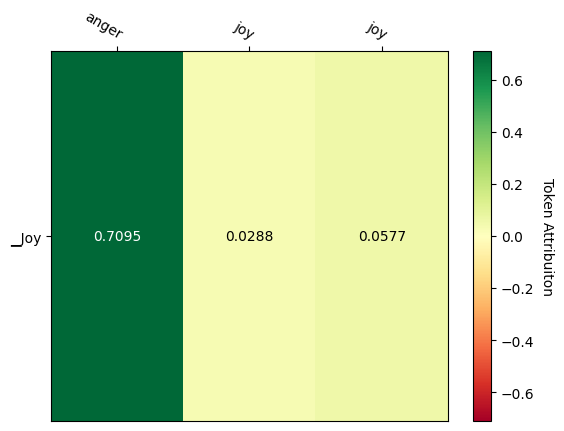

In [91]:
sentence = "anger joy joy"
eval_prompt = f"""[INST] In this task, you will be performing a classification exercise aimed at identifying the underlying emotion conveyed by a given sentence. The emotions to consider are as follows: Anger, Joy, Sadnes, Guilt, Shame, fear or disgust Sentence: {sentence} [/INST] """


model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")
model.eval()
with torch.no_grad():
    output_ids = model.generate(model_input["input_ids"], max_new_tokens=3)[0]
    response = tokenizer.decode(output_ids, skip_special_tokens=True)
    print(response)

response = response.split("[/INST]")[1]

fa = FeatureAblation(model)

llm_attr = LLMAttribution(fa, tokenizer)


inp = TextTokenInput(
    eval_prompt, 
    tokenizer,
    skip_tokens=[1],  # skip the special token for the start of the text <s>
)

target = response.split()[0]

attr_res = llm_attr.attribute(inp, target=target)


print("attr to the output sequence:", attr_res.seq_attr.shape)  # shape(n_input_token)
print("attr to the output tokens:", attr_res.token_attr.shape)  # shape(n_output_token, n_input_token)



# Assuming 'sentence' is a predefined variable containing the text to be split.
words = sentence.split(' ')
placeholders = ' '.join(['{}'] * len(words))

inp = TextTemplateInput(
    template=f"[INST] In this task, you will be performing a classification exercise aimed at identifying the underlying emotion conveyed by a given sentence. The emotions to consider are as follows: Anger, Joy, Sadness, Guilt, Shame, Fear, or Disgust. Sentence: {placeholders} [/INST]",
    values=words,
)

attr_res = llm_attr.attribute(inp, target=target)

attr_res.plot_token_attr(show=True)


In [75]:
response.split()[0]

'Disgust'

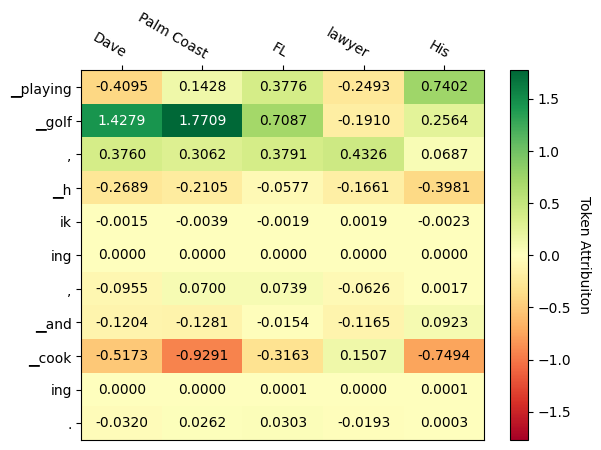

In [12]:
inp = TextTemplateInput(
    template="{} lives in {}, {} and is a {}. {} personal interests include", 
    values=["Dave", "Palm Coast", "FL", "lawyer", "His"],
    baselines=["Sarah", "Seattle", "WA", "doctor", "Her"],
)

attr_res = llm_attr.attribute(inp, target=target)

attr_res.plot_token_attr(show=True)

In [13]:
baselines = ProductBaselines(
    {
        ("name", "pronoun"):[("Sarah", "her"), ("John", "His"), ("Martin", "His"), ("Rachel", "Her")],
        ("city", "state"): [("Seattle", "WA"), ("Boston", "MA")],
        "occupation": ["doctor", "engineer", "teacher", "technician", "plumber"], 
    }
)

inp = TextTemplateInput(
    "{name} lives in {city}, {state} and is a {occupation}. {pronoun} personal interests include", 
    values={"name":"Dave", "city": "Palm Coast", "state": "FL", "occupation":"lawyer", "pronoun":"His"}, 
    baselines=baselines,
    mask={"name":0, "city": 1, "state": 1, "occupation": 2, "pronoun": 0},
)

attr_res = llm_attr.attribute(inp, target=target, num_trials=3)


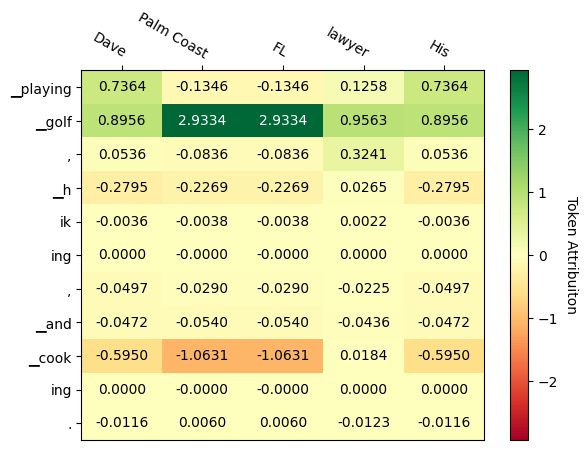

In [14]:
sv = ShapleyValues(model) 

sv_llm_attr = LLMAttribution(sv, tokenizer)

attr_res = sv_llm_attr.attribute(inp, target=target, num_trials=3)

attr_res.plot_token_attr(show=True)